In [0]:
import os
import shutil
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm_notebook
import copy
from collections import Counter
train_on_gpu = torch.cuda.is_available()

In [51]:
if 'staticmap' not in os.listdir():
    os.system('wget https://raw.githubusercontent.com/arohanajit/building-classification/master/staticmap.zip')
    with ZipFile('staticmap.zip','r') as zip:
        zip.extractall()
    os.remove('staticmap.zip')
    print(os.listdir("staticmap"))
else:
    print("Dataset already present!",os.listdir("staticmap"))

Dataset already present! ['test', 'train', '.DS_Store']


In [61]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [0]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224,scale=(0.08,1.0)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


In [92]:
total_data =  datasets.ImageFolder('staticmap', transform=transform)
num_workers = 0
batch_size = 20
valid_size = 0.2
train_data =  datasets.ImageFolder('staticmap/train', transform=transform)
test_data =  datasets.ImageFolder('staticmap/test', transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
print("Training: {}, Test:{}".format(num_train,len(test_data)))

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)



Training: 2013, Test:300


Define Classes

In [93]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
classes = ['residential','warehouse']
print([classes[0] if i==0 else classes[1] for i in labels])

['residential', 'residential', 'warehouse', 'warehouse', 'warehouse', 'warehouse', 'residential', 'residential', 'warehouse', 'warehouse', 'warehouse', 'residential', 'warehouse', 'residential', 'warehouse', 'residential', 'warehouse', 'residential', 'warehouse', 'residential']


### Visualize a Batch of Training Data

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

torch.Size([20, 3, 224, 224])


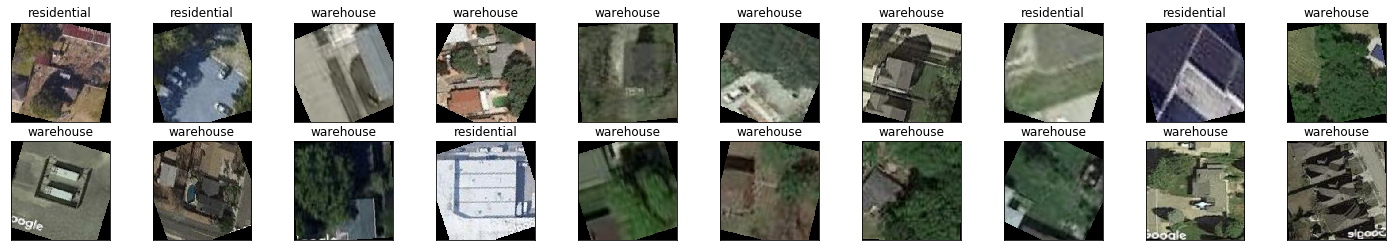

In [95]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
images = images.numpy() 
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

Text(0.5, 1.0, 'Class Distribution')

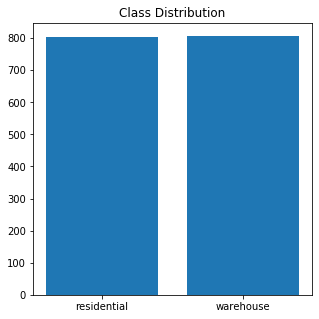

In [96]:
#Check for class imbalance
count = Counter()
for _,label in train_loader:
    count.update(label.tolist())
values = list(count.values())
fig,ax1 = plt.subplots(1,1,figsize=(5,5))
ax1.bar(classes,values)
ax1.set_title('Class Distribution')

In [0]:
model = torchvision.models.densenet121(pretrained=True)
model.classifier = nn.Linear(1024,2,bias=True)
for params in  model.parameters():
    params.requires_grad = False
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(1024,2,bias=True)
)
for params in model.classifier.parameters():
    params.requires_grad = True

Define creterion and optimizer 

In [98]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [99]:
import pandas as pd
epochs = 10
steps = 0
running_loss = 0
print_every = 5
train_stats = pd.DataFrame(columns = ['Epoch',  'Train loss',
                                      'Test loss'])
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        logps = model(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
            train_stats = train_stats.append({'Epoch': epoch, 
                                              'Train loss' : running_loss/len(train_loader),
                                     'Test loss' : test_loss/len(test_loader)}, ignore_index=True)
            running_loss = 0
            model.train()

Epoch 1/10.. Train loss: 0.909.. Test loss: 0.685.. Test accuracy: 0.523
Epoch 1/10.. Train loss: 0.781.. Test loss: 0.701.. Test accuracy: 0.540
Epoch 1/10.. Train loss: 0.729.. Test loss: 0.678.. Test accuracy: 0.557
Epoch 1/10.. Train loss: 0.690.. Test loss: 0.652.. Test accuracy: 0.607
Epoch 1/10.. Train loss: 0.660.. Test loss: 0.580.. Test accuracy: 0.767
Epoch 1/10.. Train loss: 0.654.. Test loss: 0.541.. Test accuracy: 0.790
Epoch 1/10.. Train loss: 0.650.. Test loss: 0.595.. Test accuracy: 0.647
Epoch 1/10.. Train loss: 0.630.. Test loss: 0.526.. Test accuracy: 0.787
Epoch 1/10.. Train loss: 0.609.. Test loss: 0.466.. Test accuracy: 0.853
Epoch 1/10.. Train loss: 0.589.. Test loss: 0.465.. Test accuracy: 0.803
Epoch 1/10.. Train loss: 0.508.. Test loss: 0.444.. Test accuracy: 0.867
Epoch 1/10.. Train loss: 0.539.. Test loss: 0.417.. Test accuracy: 0.873
Epoch 1/10.. Train loss: 0.537.. Test loss: 0.413.. Test accuracy: 0.880
Epoch 1/10.. Train loss: 0.486.. Test loss: 0.412..

Visualize Loss History

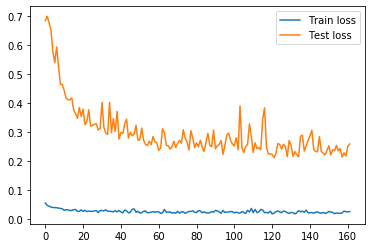

In [100]:
train_loss = list(train_stats['Train loss'])
test_loss = list(train_stats['Test loss'])
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['Train loss','Test loss'])

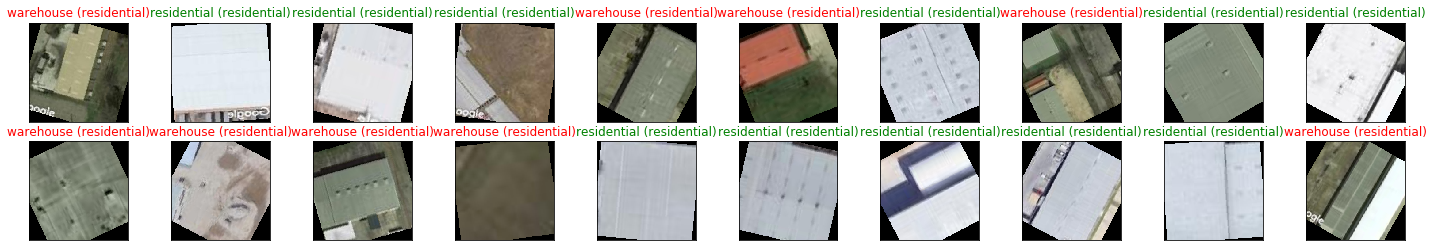

In [101]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))